The gender gap in wages has been shown [many times][1] in different papers. Quite consistently, researchers find that there's a 20-30% gap between average wages, which is reduced to 5-10% when adjusting for all the factors.

Can we reproduce these results with the IBM data set?

##*Important comment - as it turns out this is a fictional data, the conclusions should not be taken seriously. The analysis process might still be interesting though. This is probably why it seems that the wage gap is tiny and elusive.##

  [1]: https://www.glassdoor.com/research/studies/gender-pay-gap/

In [36]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from subprocess import check_output
from collections import OrderedDict
matplotlib.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")


In [14]:
path = '../input/'
filename = 'WA_Fn-UseC_-HR-Employee-Attrition.csv'

df = pd.read_csv(path + filename)

df.head(50)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
5,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6
6,59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0
7,30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,4,Male,67,3,1,Laboratory Technician,3,Divorced,2693,13335,1,Y,No,22,4,2,80,1,1,2,3,1,0,0,0
8,38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,4,Male,44,2,3,Manufacturing Director,3,Single,9526,8787,0,Y,No,21,4,2,80,0,10,2,3,9,7,1,8
9,36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,3,Male,94,3,2,Healthcare Representative,3,Married,5237,16577,6,Y,No,13,3,2,80,2,17,3,2,7,7,7,7


Let's explore the income distribution for men and women:

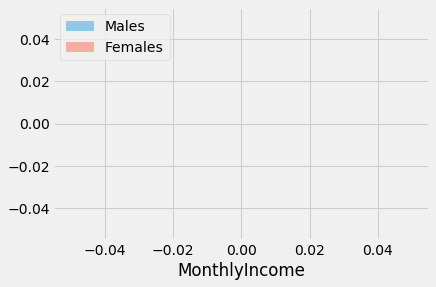

In [37]:
sns.distplot(df.MonthlyIncome[df.Gender == 'Male'], bins = np.linspace(0,20000,60))
sns.distplot(df.MonthlyIncome[df.Gender == 'Female'], bins = np.linspace(0,20000,60))
plt.legend(['Males','Females'])

Interestingly, the males histogram does not seem to be more to the right. let's quantify it and see whether the mean and median tell a different story:

1.0479677155907092


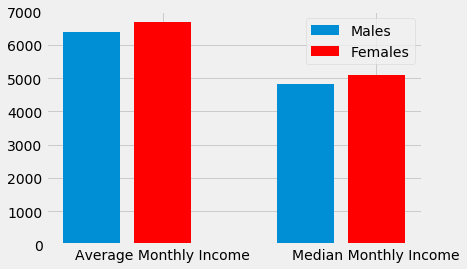

In [16]:
avg_male = np.mean(df.MonthlyIncome[df.Gender == 'Male'])
avg_female = np.mean(df.MonthlyIncome[df.Gender == 'Female'])

med_male = np.median(df.MonthlyIncome[df.Gender == 'Male'])
med_female = np.median(df.MonthlyIncome[df.Gender == 'Female'])

std_male = np.std(df.MonthlyIncome[df.Gender == 'Male'])
std_female = np.std(df.MonthlyIncome[df.Gender == 'Female'])

plt.bar([1,4],[avg_male, med_male])
plt.bar([2,5],[avg_female, med_female], color = 'r')
plt.xticks([2,5],['Average Monthly Income','Median Monthly Income'])
plt.legend(['Males','Females'])

print(avg_female/avg_male)

Surprisingly, a woman makes 1.04$ for each 1$ a man earns. So where is the wage gap? 

Let's adjust for the different features. first, see if the monthly rate is different. I was assuming that the rate would be the income divided by the monthly hours. But this does not seem to be case, so I am not sure what is the meaning of this feature. Let's explore it nonetheless:

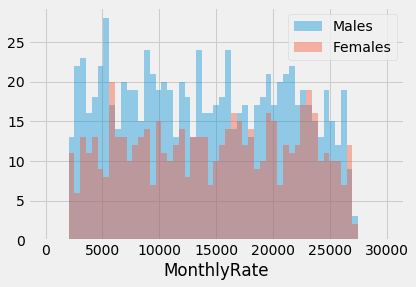

1.0428148368014205


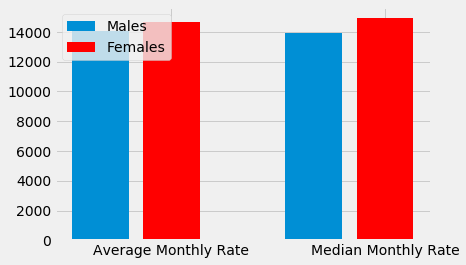

In [17]:
sns.distplot(df.MonthlyRate[df.Gender == 'Male'], bins = np.linspace(0,30000,60), kde = False)
sns.distplot(df.MonthlyRate[df.Gender == 'Female'],bins = np.linspace(0,30000,60), kde = False)
plt.legend(['Males','Females'])
plt.show()

avg_male_rate = np.mean(df.MonthlyRate[df.Gender == 'Male'])
avg_female_rate = np.mean(df.MonthlyRate[df.Gender == 'Female'])

med_male_rate = np.median(df.MonthlyRate[df.Gender == 'Male'])
med_female_rate = np.median(df.MonthlyRate[df.Gender == 'Female'])

plt.bar([1,4],[avg_male_rate, med_male_rate])
plt.bar([2,5],[avg_female_rate, med_female_rate], color = 'r')
plt.xticks([2,5],['Average Monthly Rate','Median Monthly Rate'])
plt.legend(['Males','Females'], loc = 2)

print(avg_female_rate/avg_male_rate)

Just like with the average income, the females rate is higher.  The ratio is identical - the average female rate is 4% higher. So whatever this feature is, it is highly correlated with the income. 

Let's continue our naive approach of controlling for different factors, before engaging in regressions. 

Now we will look at the different departments:

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


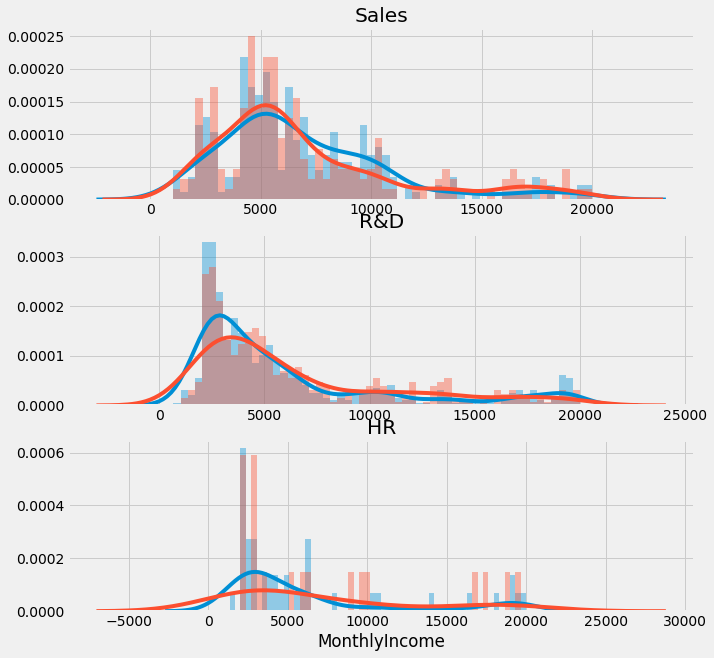

In [18]:
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.title('Sales')
sns.distplot(df.MonthlyIncome[(df.Department == 'Sales') & (df.Gender == 'Male')], bins = np.linspace(0,20000,60))
sns.distplot(df.MonthlyIncome[(df.Department == 'Sales') & (df.Gender == 'Female')], bins = np.linspace(0,20000,60))
plt.xlabel('')

plt.subplot(3,1,2)
plt.title('R&D')
sns.distplot(df.MonthlyIncome[(df.Department == 'Research & Development') & (df.Gender == 'Male')], bins = np.linspace(0,20000,60))
sns.distplot(df.MonthlyIncome[(df.Department == 'Research & Development') & (df.Gender == 'Female')], bins = np.linspace(0,20000,60))
plt.xlabel('')

plt.subplot(3,1,3)
plt.title('HR')
sns.distplot(df.MonthlyIncome[(df.Department == 'Human Resources') & (df.Gender == 'Male')], bins = np.linspace(0,20000,60))
sns.distplot(df.MonthlyIncome[(df.Department == 'Human Resources') & (df.Gender == 'Female')], bins = np.linspace(0,20000,60))

It seems that sales is the only department where males earn more on average. Let's see how this quantifies:

Text(0, 0.5, 'Average Monthly Income')

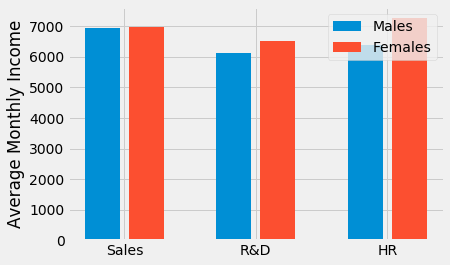

In [19]:
males_sales = np.mean(df.MonthlyIncome[(df.Department == 'Sales') & (df.Gender == 'Male')])
females_sales = np.mean(df.MonthlyIncome[(df.Department == 'Sales') & (df.Gender == 'Female')])

males_rnd = np.mean(df.MonthlyIncome[(df.Department == 'Research & Development') & (df.Gender == 'Male')])
females_rnd = np.mean(df.MonthlyIncome[(df.Department == 'Research & Development') & (df.Gender == 'Female')])

males_HR = np.mean(df.MonthlyIncome[(df.Department == 'Human Resources') & (df.Gender == 'Male')])
females_HR = np.mean(df.MonthlyIncome[(df.Department == 'Human Resources') & (df.Gender == 'Female')])


plt.bar([1,4,7],[males_sales,males_rnd,males_HR])
plt.bar([2,5,8],[females_sales,females_rnd,females_HR])

plt.xticks([1.5,4.5,7.5],['Sales','R&D','HR'])
plt.legend(['Males','Females'])
plt.ylabel('Average Monthly Income')

The average male at the sales department still earns less than the average female, though the difference is smaller compared to the other departments. Also, looking at the histograms it is clear that the average is not the best metric.

So let us see if we can use a regression in order to determine the influence of the gender feature on the income (as well as predicting the salary of an employee, if we're already here. A reasonable score of this model is of course also necessary to validate our model it meaningful and not over-fitting)

## Regression

Let's start with a small number of features:

Test set R^2... 0.597318887413701
Training set R^2... 0.6035021972222805


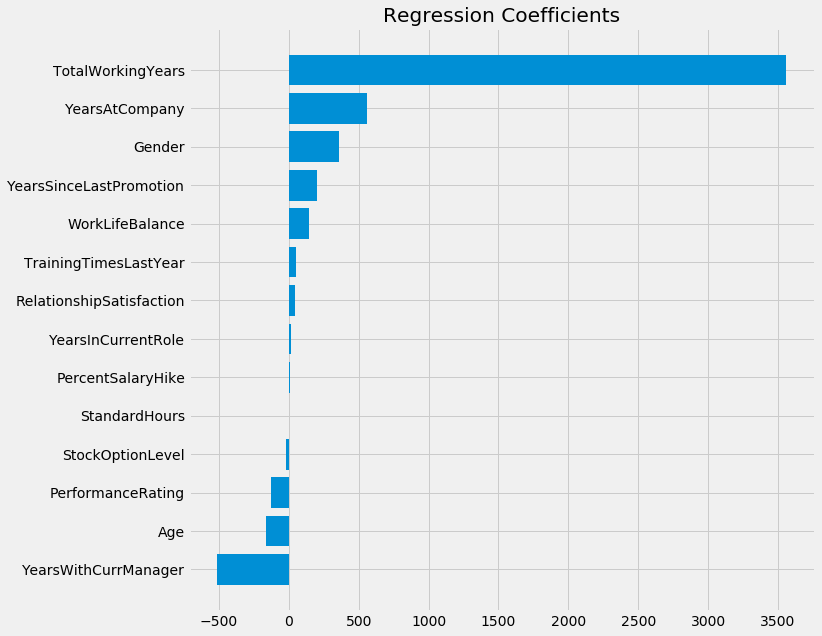

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

model = LinearRegression()
df.Gender[df.Gender == 'Male'] = 0
df.Gender[df.Gender == 'Female'] = 1

from sklearn.model_selection import train_test_split


columns = ['Age', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction','StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']

X = df[columns]

df_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(df_std)
df_std.columns = columns
df_std['Gender'] = df.Gender
y = df.MonthlyIncome

columns = ['Age', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction','StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager','Gender']

X_train, X_test, y_train, y_test = train_test_split(df_std, y, test_size=0.33, random_state=42)

model.fit(X_train,y_train)

def multiassign(d, keys, values):
    d.update(zip(keys, values))
    
plot_dict = dict()
multiassign(plot_dict,columns,model.coef_)
plot_dict = OrderedDict(sorted(plot_dict.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize = (10,10))
ax.barh(range(len(columns)),list(plot_dict.values()), align='center')
ax.set_yticks(range(len(columns)))
ax.set_yticklabels(plot_dict.keys())

ax.set_title('Regression Coefficients')

print('Test set R^2...',model.score(X_test,y_test))
print('Training set R^2...',model.score(X_train,y_train))

By far the most important feature for the regression is the total working years, which makes sense. As females were coded as "1" in the binary feature "Gender", we see that the gender coefficient is positive. which means that based on this model, being a female is correlative with higher wages even when controlling for the age, working years, etc.

Our model, however, has a relatively low R^2 value based on what I would expect. Let's add more features to the pot and see what can we cook out of it:

Test set R^2... 0.8974780059849327
Training set R^2... 0.9103490636019058


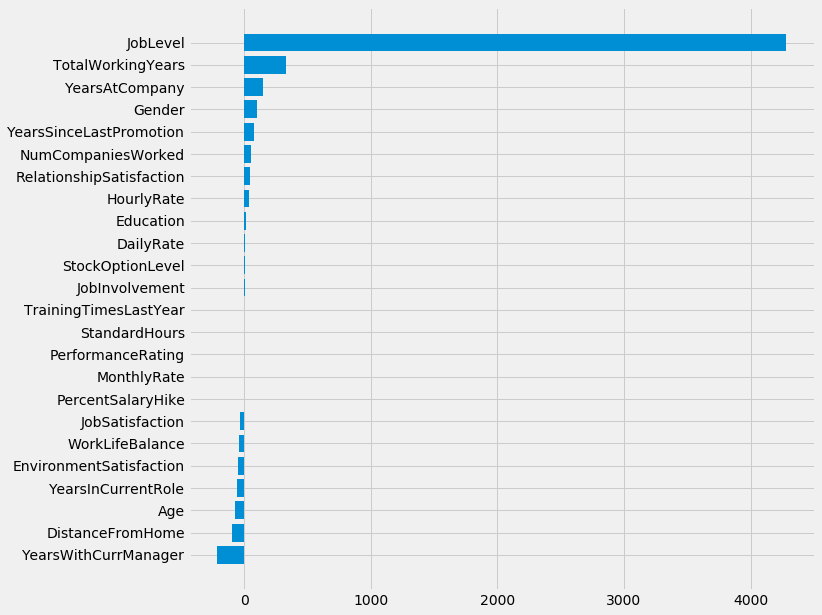

In [40]:
model = LinearRegression()


columns = ['Age', 'DailyRate', 
       'DistanceFromHome', 'Education', 
         'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']

X = df[columns]

df_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(df_std)
df_std.columns = columns
df_std['Gender'] = df.Gender
y = df.MonthlyIncome

columns =  ['Age', 'DailyRate', 
        'DistanceFromHome', 'Education', 
         'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel','JobSatisfaction',
       'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager','Gender']

X_train, X_test, y_train, y_test = train_test_split(df_std, y, test_size=0.33, random_state=42)

model.fit(X_train,y_train)

plot_dict = dict()
multiassign(plot_dict,columns,model.coef_)
plot_dict = OrderedDict(sorted(plot_dict.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize = (10,10))
ax.barh(range(len(columns)),list(plot_dict.values()), align='center')
ax.set_yticks(range(len(columns)))
ax.set_yticklabels(plot_dict.keys())

print('Test set R^2...',model.score(X_test,y_test))
print('Training set R^2...',model.score(X_train,y_train))

While the model now scores much better, I am quite suspicious about the Job Level feature. This might be considered as a leak, as it probably a very very strong proxy to the income. Let's see how the salary depends on the strongest features:

Text(0, 0.5, 'Monthly Income')

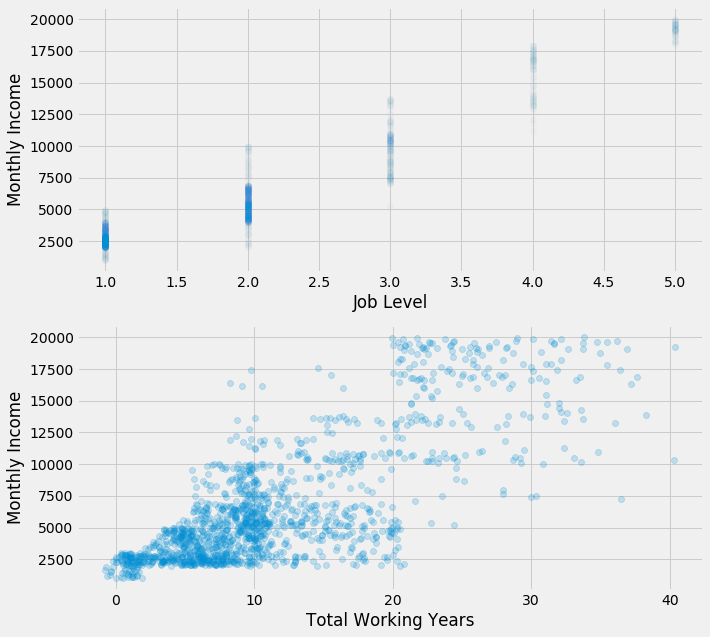

In [22]:
plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.plot(df.JobLevel,df.MonthlyIncome,'o', alpha = 0.01)
plt.xlabel('Job Level')
plt.ylabel('Monthly Income')

plt.subplot(2,1,2)
plt.plot(df.TotalWorkingYears + np.random.normal(0,0.5,len(df)),df.MonthlyIncome,'o', alpha = 0.2)
plt.xlabel('Total Working Years')
plt.ylabel('Monthly Income')

I would not consider the Job Level as a good feature when we try to predict the income based on features which are supposed to be at least somewhat non-correlated with the target (otherwise what is the point). 

The total working years is more legit in my opinion, though the distribution is a bit odd and seems unnatural (with a very large amount of employees working for 10 years):

Text(0, 0.5, 'Number of Employees')

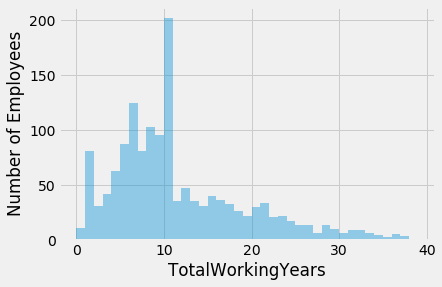

In [41]:
sns.distplot(df.TotalWorkingYears, bins = np.arange(min(df.TotalWorkingYears),max(df.TotalWorkingYears),1), kde =False)
plt.ylabel('Number of Employees')

Do all the other features, besides JobLevel, even matter? that is, how would a regression model based only on the Job Level feature would perform? 

In [42]:
model = LinearRegression()

columns = [ 'JobLevel']

X = df[columns]

df_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(df_std)
df_std.columns = columns

y = df.MonthlyIncome

columns = [ 'JobLevel']

X_train, X_test, y_train, y_test = train_test_split(df_std, y, test_size=0.33, random_state=42)

model.fit(X_train,y_train)

print('Test set R^2...',model.score(X_test,y_test))
print('Training set R^2...',model.score(X_train,y_train))

Test set R^2... 0.8942062309758405
Training set R^2... 0.9067279825176399


As I suspected - about 90% of the variance can be explained by this feature. Therefor, I would omit it from here on. Let's see how our model performs without that, but using all the other continuous features: 

Test set R^2... 0.5904457389475912
Training set R^2... 0.6065061530607114


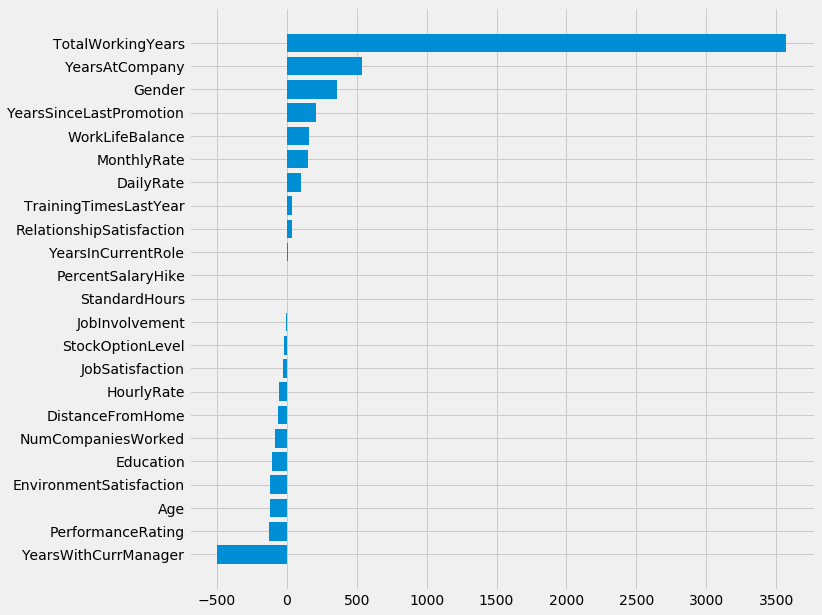

In [44]:
model = LinearRegression()


columns = ['Age', 'DailyRate', 
       'DistanceFromHome', 'Education', 
         'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement','JobSatisfaction',
       'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']

X = df[columns]

df_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(df_std)
df_std.columns = columns
df_std['Gender'] = df.Gender
y = df.MonthlyIncome

columns =  ['Age', 'DailyRate', 
        'DistanceFromHome', 'Education', 
         'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement','JobSatisfaction',
       'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager','Gender']

X_train, X_test, y_train, y_test = train_test_split(df_std, y, test_size=0.33, random_state=42)

model.fit(X_train,y_train)

plot_dict = dict()
multiassign(plot_dict,columns,model.coef_)
plot_dict = OrderedDict(sorted(plot_dict.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize = (10,10))
ax.barh(range(len(columns)),list(plot_dict.values()), align='center')
ax.set_yticks(range(len(columns)))
ax.set_yticklabels(plot_dict.keys())

print('Test set R^2...',model.score(X_test,y_test))
print('Training set R^2...',model.score(X_train,y_train))

 1. The Gender coefficient is still positive
 2. The general performance of the model has not improved much compared to our initial benhmark which used only a handful of features 

Let's see if the categorical features can improve the situation. 

first. we'll have to code them into binary features for each category (one hot encoding):

In [45]:
categorical = pd.get_dummies(df[['EducationField','JobRole','MaritalStatus','Department']])
categorical['Gender'] = df.Gender
categorical = categorical.drop(['EducationField_Human Resources','JobRole_Healthcare Representative','Department_Human Resources','MaritalStatus_Divorced'], axis = 1)

Test set R^2... 0.7854016188404057
Training set R^2... 0.8287075762033094


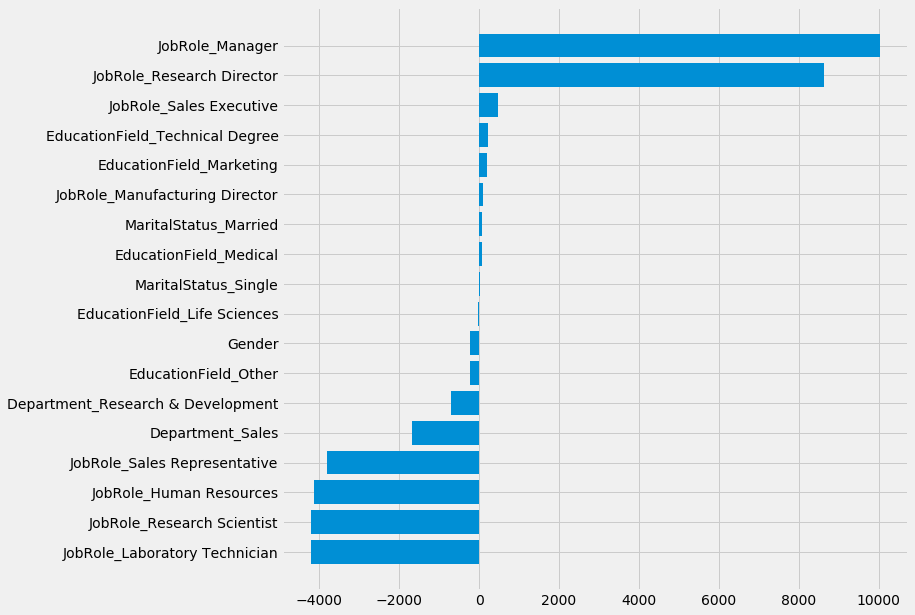

In [46]:
model = LinearRegression()

X = categorical
y = df.MonthlyIncome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model.fit(X_train,y_train)

plot_dict = dict()
multiassign(plot_dict,categorical.columns,model.coef_)
plot_dict = OrderedDict(sorted(plot_dict.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize = (10,10))
ax.barh(range(len(categorical.columns)),list(plot_dict.values()), align='center')
ax.set_yticks(range(len(categorical.columns)))
ax.set_yticklabels(plot_dict.keys())

print('Test set R^2...',model.score(X_test,y_test))
print('Training set R^2...',model.score(X_train,y_train))

The categorical model performs much better, with the job role being the most important feature (as one can expect). This looks like a better control.

Also, the gender coefficient is, finally, negative.

## Have we found the gender gap? 

Let's rejoin all the legitimate features to our final linear regression:

In [47]:
result = pd.concat([df, categorical], axis=1)

Test set R^2... 0.8682605672679643
Training set R^2... 0.8837324003282252


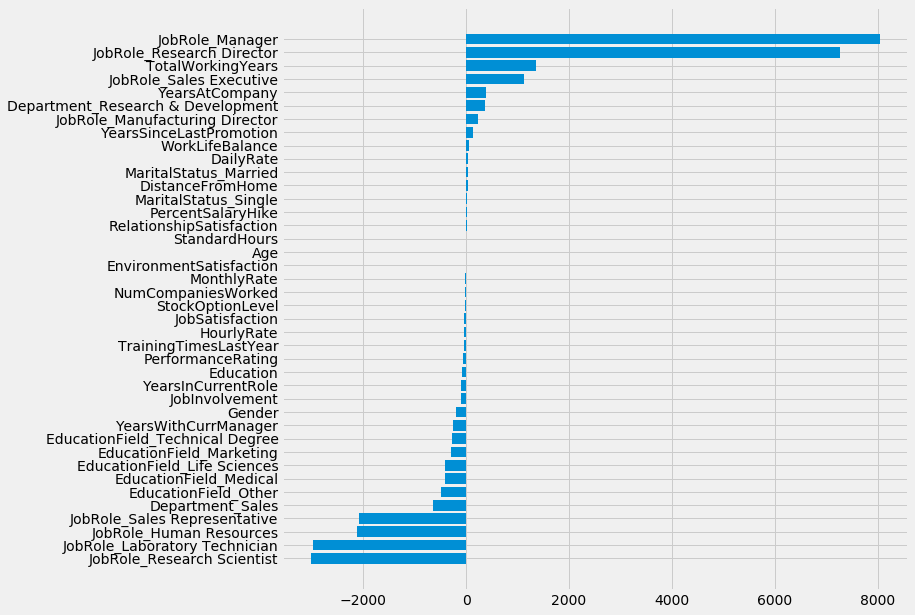

In [48]:
model = LinearRegression()


columns = ['Age', 'DailyRate', 
       'DistanceFromHome', 'Education', 
         'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement','JobSatisfaction',
       'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']

X = df[columns]

df_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(df_std)
df_std.columns = columns
df_std['Gender'] = df.Gender
df_std = pd.concat([df_std,categorical.drop(['Gender'],axis = 1)],axis = 1)
y = df.MonthlyIncome


X_train, X_test, y_train, y_test = train_test_split(df_std, y, test_size=0.33, random_state=42)

model.fit(X_train,y_train)

plot_dict = dict()
multiassign(plot_dict,df_std.columns,model.coef_)
plot_dict = OrderedDict(sorted(plot_dict.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize = (10,10))
ax.barh(range(len(df_std.columns)),list(plot_dict.values()), align='center')
ax.set_yticks(range(len(df_std.columns)))
ax.set_yticklabels(plot_dict.keys())

print('Test set R^2...',model.score(X_test,y_test))
print('Training set R^2...',model.score(X_train,y_train))

Using all the features we get a validation score which is almost as high as the validation score using the Job level feature which is a great predictor for the income. and with this model, we see that the gender coefficient is indeed negative - that is, when controlling for all the available features, the contributing of being a female to the wage is negative. 

Based on this analysis, the wage gap is, sadly, observed in this data set too. although much more elusive than usually. 

One can of course wonder whether the fact that I was clearly looking for a certain conclusion impaired the statistical inference process. Do tell me your opinion in the comment section!

## And again, since it turns out the data is fictional, do not conclude anything too dramatic :) ##
